In [12]:
# %matplotlib inline

import os

import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
# device = torch.device("mps") if torch.backends.mps.is_built() else torch.device("cpu")
device = torch.device("cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SPEECH_FILE = "data/speech.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs("data", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)

1.12.1
0.12.1
cpu


In [13]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("Sample Rate:", bundle.sample_rate)
print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [14]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [15]:
IPython.display.Audio(SPEECH_FILE)

In [16]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [17]:
# Wav2Vec2 models fine-tuned for ASR task can perform feature extraction and
# classification with one step, but for the sake of the tutorial, we also show 
# how to perform feature extraction here.
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

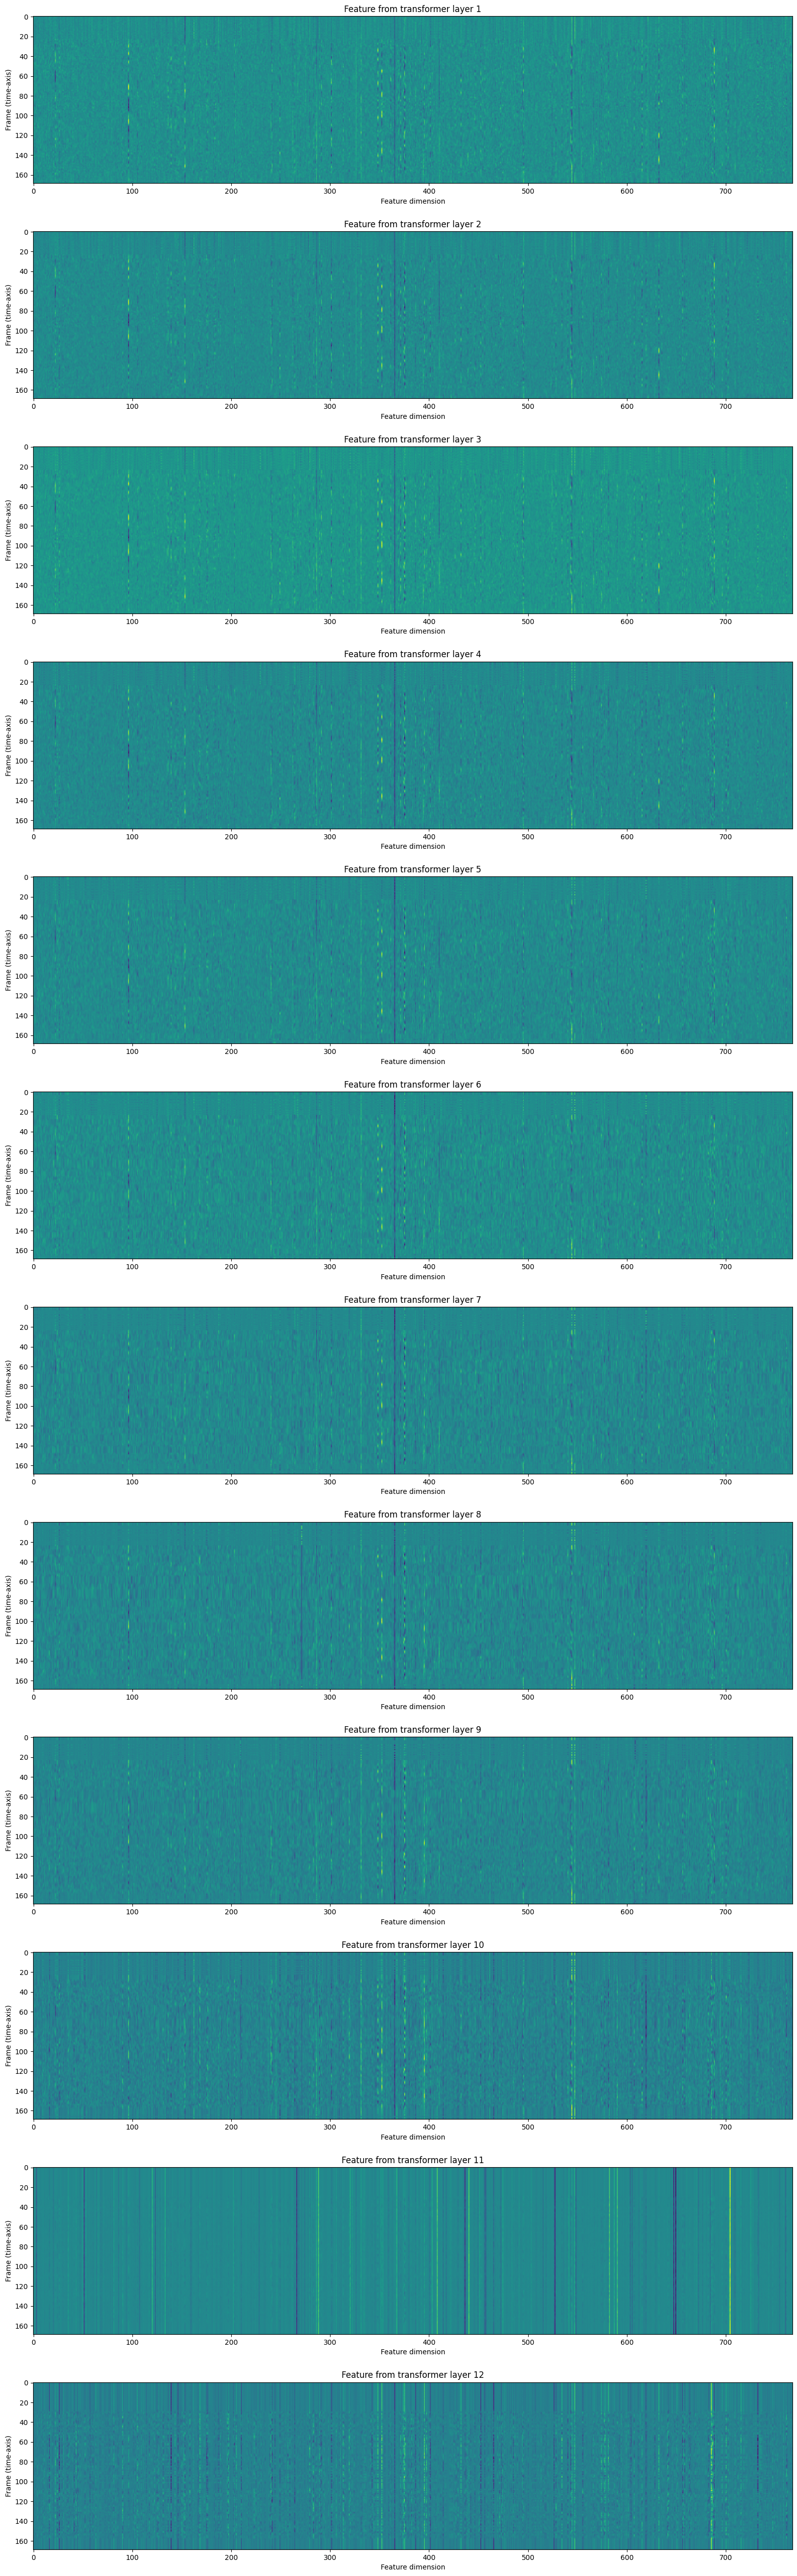

In [18]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [20]:
# Once the acoustic features are extracted, the next step is to classify them 
# into a set of categories.
# Wav2Vec2 model provides method to perform the feature extraction and 
# classification in one step.

with torch.inference_mode():
    emission, _ = model(waveform)

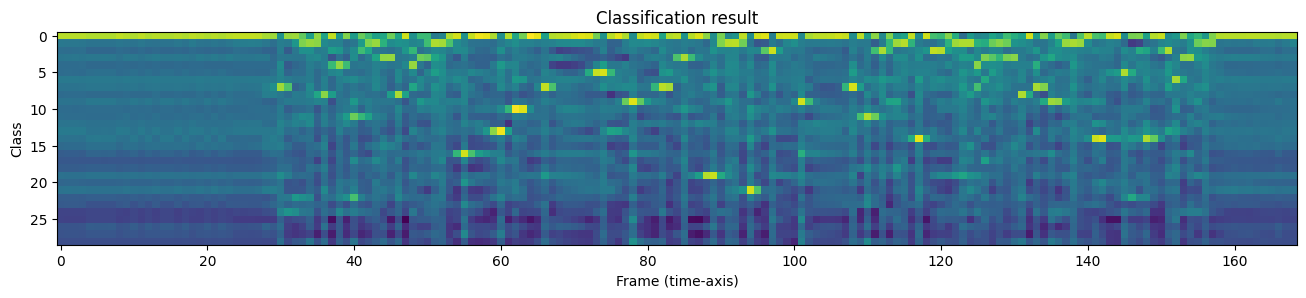

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [22]:
# The output is in the form of logits. It is not in the form of probability.

plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In this tutorial, for the sake of simplicity, we will perform greedy decoding 
which does not depend on such external components, and simply pick up the best 
hypothesis at each time step. Therefore, the context information is not used
and only one transcript can be generated.

In [23]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [24]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [25]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


In this tutorial, we looked at how to use torchaudio.pipelines to perform acoustic feature extraction and speech recognition. Constructing a model and getting the emission is as short as two lines.

```
model = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()
emission = model(waveforms, ...)
```